In [11]:
import sbol2
import os
from rdflib import Graph
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import subprocess
import tempfile
from rdflib.query import ResultRow
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
import random
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GCNConv, GATConv, global_mean_pool, to_hetero
import sys 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pickle
python_executable = sys.executable


In [2]:
current_dir = os.path.abspath('')
data_path = os.path.join(current_dir, '..', 'data')
attachments_path = os.path.join(current_dir, '..', 'attachments')
pulled_attachments_path = os.path.join(current_dir, '..', 'pulled_attachments')
sbol_path = os.path.join(current_dir, '..', 'sbol_data')
downloaded_sbol_path = os.path.join(current_dir, '..', 'downloaded_sbol')
original_data_path = os.path.join(data_path, 'original_data')
nt_path = os.path.join(current_dir, '..', 'nt_data')
scripts_path = os.path.join(current_dir, 'scripts')
model_data_path = os.path.join(data_path, 'processed_data', 'replicated_models')
model_output_path = os.path.join('..', 'model_outputs')

In [ ]:
def xml_to_nt_and_get_y_measure(file_name):
    g = Graph()
    g.parse(os.path.join(sbol_path, file_name), format="xml")
    g.serialize(destination=os.path.join(nt_path, file_name.replace(".xml", ".nt")), format="nt")

    sparql_query ='''PREFIX om: <http://www.ontology-of-units-of-measure.org/resource/om-2/>

    SELECT ?numericalValue
    WHERE {
    ?s om:hasNumericalValue ?numericalValue .
    }
    '''
    query_result = g.query(sparql_query)

    # Process the results
    if query_result:
        for row in query_result:
            if isinstance(row, ResultRow):
                return float(row.numericalValue) 
                
            else:
                print(row)
    else:
        print("No numerical values found.")
    

def convert_all_xml_to_nt_and_get_y_measures():
    y_measures = []
    for i, file_name in enumerate(os.listdir(os.path.join(sbol_path))):
        y = xml_to_nt_and_get_y_measure(file_name)
        y_measures.append(y)
        if (i == 250):
            break
        print(file_name)
    return y_measures

def return_heterograph_for_one_nt(nt_file_name, node_names, edge_names):
    
    with tempfile.TemporaryDirectory() as temp_dir:
        save_path_numeric = os.path.join(temp_dir, "save_path_numeric")
        path = os.path.join(temp_dir, "path")
        os.makedirs(save_path_numeric, exist_ok=True)
        os.makedirs(path, exist_ok=True)

        content_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [NLD]
        nld_class = ModuleDefinition

        [EMBEDDING]
        embedding_model = allenai/scibert_scivocab_uncased

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [N-ArayFeaturePath]
        ComponentDefinition_Range_feature_path = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location

        [N-ArayFeatureValue]
        ComponentDefinition_Range_feature_value = http://sbols.org/v2#start, http://sbols.org/v2#end
        '''

        topo_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [MODEL] ;required, options = transe / complex / distmult / rotate
        kge_model = distmult

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [EmbeddingClasses] 
        class_list = http://sbols.org/v2#ComponentDefinition, http://sbols.org/v2#Sequence, http://sbols.org/v2#ModuleDefinition, http://sbols.org/v2#Module, http://sbols.org/v2#FunctionalComponent, http://sbols.org/v2#Component, http://sbols.org/v2#SequenceAnnotation, http://sbols.org/v2#Range

        [EmbeddingPredicates] 
        pred_list = http://sbols.org/v2#location, http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#functionalComponent, http://sbols.org/v2#definition, http://sbols.org/v2#module, http://sbols.org/v2#component, https://sbols.org/v2#sequence, http://www.w3.org/1999/02/22-rdf-syntax-ns#type
        '''

        with open(os.path.join(temp_dir,'config.ini'), 'w') as file:
            file.write(content_config_string)

        with open(os.path.join(temp_dir,'topo-config.ini'), 'w') as file:
            file.write(topo_config_string)

        content_result = subprocess.run([python_executable, "autordf2gml.py", "--config_path", os.path.join(temp_dir,"config.ini")], shell=False, capture_output=True, text=True)
        topo_result = subprocess.run([python_executable, "autordf2gml-tb.py", "--config_path", os.path.join(temp_dir,"topo-config.ini")], shell=False, capture_output=True, text=True, encoding='utf-8', errors='replace')

        print(topo_result.stderr)
        if (topo_result.returncode == 0):
            print("topology-based conversion done!")
        else:
            print(f"topology-based conversion failed with return code {topo_result.returncode}.")

        
        data = HeteroData()
        local_indices_map = {}            

        for node_name in node_names:
            node_features_df = pd.read_csv(os.path.join(save_path_numeric, f'pivoted_df_{node_name}.csv'), header=None).astype(float)
            node_tensor = torch.tensor(node_features_df.values, dtype=torch.float)
            id_mapping_df = pd.read_csv(os.path.join(path, f'pivoted_df_{node_name}.csv'))
            subject_mapping_dict = id_mapping_df.set_index('subject')['mapping'].to_dict()

            topo_df = pd.read_csv(os.path.join(save_path_numeric, f"uri_list_{node_name}.csv"))
            topo_df['mapped_col'] = topo_df['subject'].map(subject_mapping_dict)
            topo_df = topo_df.sort_values(by='mapped_col')
            topo_df = topo_df.drop(['subject', 'mapped_col'], axis=1).astype(float)
            node_tensor_topo = torch.tensor(topo_df.values, dtype=torch.float)


            print(f'{node_name}, topo shape:  {node_tensor_topo.shape}, numeric shape:  {node_tensor.shape}, filename={nt_file_name}')

            node_tensor = torch.concat([node_tensor, node_tensor_topo], dim=1)
            
            data[node_name].node_id = torch.arange(len(id_mapping_df))
            data[node_name].x = node_tensor
            local_indices_map = subject_mapping_dict | local_indices_map
                
        for edge in edge_names:
            df = pd.read_csv( os.path.join(save_path_numeric, f"edge_list_{edge}.csv"), header=None)
            
            src = df[0].values
            dst = df[1].values

            src = torch.tensor([local_indices_map[src[i]] for i in range(len(src))], dtype=torch.long)
            dst = torch.tensor([local_indices_map[dst[i]] for i in range(len(dst))], dtype=torch.long)
            data[edge.split("_")[0], f'has_{edge.split("_")[1]}', edge.split("_")[1]].edge_index = torch.stack([src, dst], dim=0)
        
        return data
    
class HeteroGNN_GraphLevel(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, num_layers):
        super().__init__()
        self.metadata = metadata  # (node_types, edge_types)
        print("Metadata: ", self.metadata[1])

        unique_nodes = set()
        
        for edge_tuple in self.metadata[1]:
            unique_nodes.add(edge_tuple[0])
            unique_nodes.add(edge_tuple[2])

        self.convs = torch.nn.ModuleList()

        for _ in range(num_layers):  # number of layers
            
            conv_dict = {}
            for edge_type in self.metadata[1]: 
                src, _, dst = edge_type
                conv_layer = GATConv((-1, -1), hidden_channels) if src == dst else SAGEConv((-1, -1), hidden_channels)

                conv_dict[edge_type] = conv_layer
            hetero_conv = HeteroConv(conv_dict, aggr='sum')
            self.convs.append(hetero_conv)            

        total_hidden = len(unique_nodes) * hidden_channels
        self.lin = torch.nn.Sequential(
            Linear(total_hidden, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.7),
            Linear(hidden_channels, 1) 
        )

    def forward(self, x_dict, edge_index_dict, batch_dict):

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {k: F.relu(v) for k, v in x_dict.items()}


        # Pool all node types, then concatenate
        pooled = [
            global_mean_pool(x_dict[node_type], batch_dict[node_type])
            for node_type in x_dict
        ]        
        graph_embeddings = torch.cat(pooled, dim=-1)  # shape: [batch_size, total_hidden]
        return self.lin(graph_embeddings).view(-1)     # shape: [batch_size]




def return_all_graphs(node_classes, y_measures, all_edges_formatted):
    all_data = []
    files = os.listdir(nt_path)
    
    for i, filename in enumerate(tqdm(files, desc="Generating graphs")):
        data = return_heterograph_for_one_nt(filename, node_classes, all_edges_formatted)
        data.y = y_measures[i]
        all_data.append(data)
        print(filename)

        if (i == 250):
            break
    
    return all_data



def evaluate_on_test(model, test_loader, device):
    model.eval()
    total_test_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
            target = batch.y.float().view(-1).to(device)
            loss = F.mse_loss(out, target)
            total_test_loss += loss.item() * batch.num_graphs

            preds.extend(out.cpu().numpy())
            trues.extend(target.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    print(f"Test Loss (MSE): {avg_test_loss}")
    return avg_test_loss, preds, trues


def train_GNN(all_data):

    random.shuffle(all_data)
    train_size = int(0.8 * len(all_data))
    train_data = all_data[:train_size]
    val_data = all_data[train_size:]

    train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=10, shuffle=False) 

    model = HeteroGNN_GraphLevel(metadata=all_data[0].metadata(), hidden_channels=64, num_layers=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    history = {
    "train_loss": [],
    "val_loss": []
    }

    for epoch in range(1, 100):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
            target = torch.tensor(batch.y, dtype=torch.float32).view(-1).to(device)
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.num_graphs

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x_dict, batch.edge_index_dict, batch.batch_dict)
                target = batch.y.float().view(-1).to(device)
                loss = F.mse_loss(out, target)
                total_val_loss += loss.item() * batch.num_graphs

        train_epoch_loss = total_train_loss / len(train_loader.dataset)
        val_epoch_loss = total_val_loss / len(val_loader.dataset)
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")
    return model, history, device



In [34]:
node_classes = [
    "ComponentDefinition",
    "Sequence",
    "ModuleDefinition",
    "Module",
    "FunctionalComponent",
    "Component",
    "SequenceAnnotation",
    "Range"
]

all_edges_formatted = [
    "ComponentDefinition_Sequence",
    "ComponentDefinition_SequenceAnnotation",
    "ComponentDefinition_Range",
    "ModuleDefinition_ComponentDefinition",
    "ModuleDefinition_ModuleDefinition",
    "ComponentDefinition_ComponentDefinition",
]

def return_standardized_labels(y_measures):
    all_y_values_np = np.array(y_measures).reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(all_y_values_np)
    return y_scaled, scaler_y



In [15]:
with open('numbers.pkl', 'rb') as file:
    y = pickle.load(file)

y_scaled, scaler_y = return_standardized_labels(y)

with open('heterographs.pkl', 'rb') as file:
    X_graphs = pickle.load(file)

for graph, y_measure in zip(X_graphs, y_scaled):
    graph.y = torch.tensor(y_measure, dtype=torch.float32)

In [ ]:
y_measures = convert_all_xml_to_nt_and_get_y_measures()
y_scaled, scaler_y = return_standardized_labels(y_measures)
X_graphs = return_all_graphs(node_classes, y_scaled, all_edges_formatted)

c:\Users\Sai\Documents\GitHub\SBOLtrainer\trainvenv\lib\site-packages\rdflib\plugins\serializers\nt.py:40: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: None
  warnings.warn(


sample_design_0.xml
sample_design_1.xml
sample_design_10.xml
sample_design_100.xml
sample_design_1000.xml
sample_design_10000.xml
sample_design_10001.xml
sample_design_10002.xml
sample_design_10003.xml
sample_design_10004.xml
sample_design_10005.xml
sample_design_10006.xml
sample_design_10007.xml
sample_design_10008.xml
sample_design_10009.xml
sample_design_1001.xml
sample_design_10010.xml
sample_design_10011.xml
sample_design_10012.xml
sample_design_10013.xml
sample_design_10015.xml
sample_design_10016.xml
sample_design_10017.xml
sample_design_10018.xml
sample_design_10019.xml
sample_design_1002.xml
sample_design_10020.xml
sample_design_10021.xml
sample_design_10022.xml
sample_design_10023.xml
sample_design_10024.xml
sample_design_10025.xml
sample_design_10026.xml
sample_design_10027.xml
sample_design_10028.xml
sample_design_10029.xml
sample_design_1003.xml
sample_design_10030.xml
sample_design_10031.xml
sample_design_10032.xml
sample_design_10033.xml
sample_design_10034.xml
sample_de

Generating graphs:   0%|          | 1/17055 [00:13<66:09:23, 13.97s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_0.nt


Generating graphs:   0%|          | 2/17055 [00:26<61:25:43, 12.97s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1.nt


Generating graphs:   0%|          | 3/17055 [00:38<59:42:12, 12.60s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10.nt


Generating graphs:   0%|          | 4/17055 [00:50<58:22:11, 12.32s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_100.nt


Generating graphs:   0%|          | 5/17055 [01:02<57:32:28, 12.15s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1000.nt


Generating graphs:   0%|          | 6/17055 [01:14<57:34:16, 12.16s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10000.nt


Generating graphs:   0%|          | 7/17055 [01:26<57:17:39, 12.10s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10001.nt


Generating graphs:   0%|          | 8/17055 [01:53<79:39:13, 16.82s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10002.nt


Generating graphs:   0%|          | 9/17055 [02:05<72:24:14, 15.29s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10003.nt


Generating graphs:   0%|          | 10/17055 [02:19<70:46:41, 14.95s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10004.nt


Generating graphs:   0%|          | 11/17055 [02:46<88:54:37, 18.78s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10005.nt


Generating graphs:   0%|          | 12/17055 [03:02<84:53:08, 17.93s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10006.nt


Generating graphs:   0%|          | 13/17055 [03:19<82:28:50, 17.42s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10007.nt


Generating graphs:   0%|          | 14/17055 [03:36<82:33:58, 17.44s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10008.nt


Generating graphs:   0%|          | 15/17055 [03:53<81:59:36, 17.32s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10009.nt


Generating graphs:   0%|          | 16/17055 [04:09<79:51:20, 16.87s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1001.nt


Generating graphs:   0%|          | 17/17055 [04:30<86:03:49, 18.18s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10010.nt


Generating graphs:   0%|          | 18/17055 [04:43<78:02:36, 16.49s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10011.nt


Generating graphs:   0%|          | 19/17055 [04:55<71:48:44, 15.18s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10012.nt


Generating graphs:   0%|          | 20/17055 [05:07<67:19:32, 14.23s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10013.nt


Generating graphs:   0%|          | 21/17055 [05:18<63:40:02, 13.46s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10015.nt


Generating graphs:   0%|          | 22/17055 [05:30<61:14:27, 12.94s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10016.nt


Generating graphs:   0%|          | 23/17055 [05:49<68:52:12, 14.56s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10017.nt


Generating graphs:   0%|          | 24/17055 [06:03<68:32:46, 14.49s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10018.nt


Generating graphs:   0%|          | 25/17055 [06:16<66:14:33, 14.00s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10019.nt


Generating graphs:   0%|          | 26/17055 [06:28<63:22:26, 13.40s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1002.nt


Generating graphs:   0%|          | 27/17055 [06:40<61:10:55, 12.93s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10020.nt


Generating graphs:   0%|          | 28/17055 [06:53<61:19:48, 12.97s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10021.nt


Generating graphs:   0%|          | 29/17055 [07:04<59:38:50, 12.61s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10022.nt


Generating graphs:   0%|          | 30/17055 [07:17<59:15:03, 12.53s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([3, 1, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10023.nt


Generating graphs:   0%|          | 31/17055 [07:52<91:40:12, 19.39s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10024.nt


Generating graphs:   0%|          | 32/17055 [08:04<81:39:56, 17.27s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10025.nt


Generating graphs:   0%|          | 33/17055 [08:17<74:53:59, 15.84s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10026.nt


Generating graphs:   0%|          | 34/17055 [08:29<69:05:18, 14.61s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10027.nt


Generating graphs:   0%|          | 35/17055 [08:40<64:50:41, 13.72s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10028.nt


Generating graphs:   0%|          | 36/17055 [08:58<70:14:33, 14.86s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10029.nt


Generating graphs:   0%|          | 37/17055 [09:10<66:02:54, 13.97s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1003.nt


Generating graphs:   0%|          | 38/17055 [09:21<62:36:52, 13.25s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10030.nt


Generating graphs:   0%|          | 39/17055 [09:33<60:35:33, 12.82s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10031.nt


Generating graphs:   0%|          | 40/17055 [09:45<58:59:57, 12.48s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10032.nt


Generating graphs:   0%|          | 41/17055 [09:57<57:54:16, 12.25s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10033.nt


Generating graphs:   0%|          | 42/17055 [10:09<57:32:57, 12.18s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10034.nt


Generating graphs:   0%|          | 43/17055 [10:44<90:19:20, 19.11s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10035.nt


Generating graphs:   0%|          | 44/17055 [11:01<87:26:36, 18.51s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10036.nt


Generating graphs:   0%|          | 45/17055 [11:17<84:03:29, 17.79s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10037.nt


Generating graphs:   0%|          | 46/17055 [11:35<84:10:46, 17.82s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10038.nt


Generating graphs:   0%|          | 47/17055 [11:52<82:30:17, 17.46s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10039.nt


Generating graphs:   0%|          | 48/17055 [12:13<88:48:08, 18.80s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1004.nt


Generating graphs:   0%|          | 49/17055 [12:29<84:36:36, 17.91s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10040.nt


Generating graphs:   0%|          | 50/17055 [12:46<83:08:54, 17.60s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10041.nt


Generating graphs:   0%|          | 51/17055 [13:07<88:06:51, 18.66s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10042.nt


Generating graphs:   0%|          | 52/17055 [13:20<79:15:38, 16.78s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10043.nt


Generating graphs:   0%|          | 53/17055 [13:32<72:21:55, 15.32s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10044.nt


Generating graphs:   0%|          | 54/17055 [13:44<67:44:25, 14.34s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10045.nt


Generating graphs:   0%|          | 55/17055 [13:56<64:53:58, 13.74s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10046.nt


Generating graphs:   0%|          | 56/17055 [14:08<62:06:28, 13.15s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10047.nt


Generating graphs:   0%|          | 57/17055 [14:20<60:31:49, 12.82s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10048.nt


Generating graphs:   0%|          | 58/17055 [14:32<59:35:21, 12.62s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10049.nt


Generating graphs:   0%|          | 59/17055 [14:44<59:08:04, 12.53s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([3, 1, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1005.nt


Generating graphs:   0%|          | 60/17055 [14:57<58:45:37, 12.45s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10050.nt


Generating graphs:   0%|          | 61/17055 [15:08<57:41:19, 12.22s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10051.nt


Generating graphs:   0%|          | 62/17055 [15:20<56:46:47, 12.03s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10052.nt


Generating graphs:   0%|          | 63/17055 [15:31<56:06:59, 11.89s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10053.nt


Generating graphs:   0%|          | 64/17055 [15:43<55:31:44, 11.77s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10054.nt


Generating graphs:   0%|          | 65/17055 [15:55<55:31:40, 11.77s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10055.nt


Generating graphs:   0%|          | 66/17055 [16:09<59:50:03, 12.68s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10056.nt


Generating graphs:   0%|          | 67/17055 [16:21<58:18:38, 12.36s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10057.nt


Generating graphs:   0%|          | 68/17055 [16:48<79:03:16, 16.75s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10058.nt


Generating graphs:   0%|          | 69/17055 [17:01<72:54:36, 15.45s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10059.nt


Generating graphs:   0%|          | 70/17055 [17:12<67:33:13, 14.32s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1006.nt


Generating graphs:   0%|          | 71/17055 [17:24<63:55:35, 13.55s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10060.nt


Generating graphs:   0%|          | 72/17055 [17:36<61:13:00, 12.98s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10061.nt


Generating graphs:   0%|          | 73/17055 [17:47<59:22:16, 12.59s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10062.nt


Generating graphs:   0%|          | 74/17055 [17:59<58:35:11, 12.42s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10063.nt


Generating graphs:   0%|          | 75/17055 [18:34<90:24:48, 19.17s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10064.nt


Generating graphs:   0%|          | 76/17055 [18:46<80:30:13, 17.07s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10065.nt


Generating graphs:   0%|          | 77/17055 [19:03<79:41:11, 16.90s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10066.nt


Generating graphs:   0%|          | 78/17055 [19:24<86:20:59, 18.31s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10067.nt


Generating graphs:   0%|          | 79/17055 [19:36<76:50:26, 16.30s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10068.nt


Generating graphs:   0%|          | 80/17055 [19:48<70:19:22, 14.91s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10069.nt


Generating graphs:   0%|          | 81/17055 [20:00<66:11:53, 14.04s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1007.nt


Generating graphs:   0%|          | 82/17055 [20:12<62:59:06, 13.36s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10070.nt


Generating graphs:   0%|          | 83/17055 [20:23<60:19:12, 12.79s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10071.nt


Generating graphs:   0%|          | 84/17055 [20:35<58:34:13, 12.42s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10072.nt


Generating graphs:   0%|          | 85/17055 [21:09<90:14:24, 19.14s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10073.nt


Generating graphs:   1%|          | 86/17055 [21:21<79:30:22, 16.87s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10074.nt


Generating graphs:   1%|          | 87/17055 [21:33<72:38:14, 15.41s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([3, 1, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10075.nt


Generating graphs:   1%|          | 88/17055 [21:45<67:29:20, 14.32s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10076.nt


Generating graphs:   1%|          | 89/17055 [21:57<64:39:55, 13.72s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 1, 3])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10077.nt


Generating graphs:   1%|          | 90/17055 [22:10<63:28:10, 13.47s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10078.nt


Generating graphs:   1%|          | 91/17055 [22:22<61:24:52, 13.03s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([0, 1])
ModuleDefinition_ModuleDefinition
tensor([0, 3, 1])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10079.nt


Generating graphs:   1%|          | 92/17055 [22:34<59:33:00, 12.64s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_1008.nt


Generating graphs:   1%|          | 93/17055 [22:45<58:04:46, 12.33s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10080.nt


Generating graphs:   1%|          | 94/17055 [23:18<86:15:53, 18.31s/it]

ComponentDefinition_Sequence
tensor([0])
ComponentDefinition_SequenceAnnotation
tensor([0])
ComponentDefinition_Range
tensor([0])
ModuleDefinition_ComponentDefinition
tensor([1, 0])
ModuleDefinition_ModuleDefinition
tensor([1, 3, 0])
ComponentDefinition_ComponentDefinition
tensor([2])
sample_design_10081.nt


In [16]:
y_scaled = y_scaled[:250]
X_graphs = X_graphs[:250]

In [17]:
train_graphs, test_graphs = train_test_split(X_graphs, test_size=0.2, random_state=42)

In [23]:
model, history, device = train_GNN(train_graphs)

Metadata:  [('ComponentDefinition', 'has_Sequence', 'Sequence'), ('ComponentDefinition', 'has_SequenceAnnotation', 'SequenceAnnotation'), ('ComponentDefinition', 'has_Range', 'Range'), ('ModuleDefinition', 'has_ComponentDefinition', 'ComponentDefinition'), ('ModuleDefinition', 'has_ModuleDefinition', 'ModuleDefinition'), ('ComponentDefinition', 'has_ComponentDefinition', 'ComponentDefinition')]


C:\Users\Sai\AppData\Local\Temp\ipykernel_25768\3765874905.py:337: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch.y, dtype=torch.float32).view(-1).to(device)


Epoch 001 | Train Loss: 0.4233 | Val Loss: 0.0009
Epoch 002 | Train Loss: 0.4306 | Val Loss: 0.0044
Epoch 003 | Train Loss: 0.4386 | Val Loss: 0.0066
Epoch 004 | Train Loss: 0.4225 | Val Loss: 0.0018
Epoch 005 | Train Loss: 0.4272 | Val Loss: 0.0019
Epoch 006 | Train Loss: 0.4183 | Val Loss: 0.0014
Epoch 007 | Train Loss: 0.4228 | Val Loss: 0.0039
Epoch 008 | Train Loss: 0.4157 | Val Loss: 0.0008
Epoch 009 | Train Loss: 0.4144 | Val Loss: 0.0012
Epoch 010 | Train Loss: 0.4026 | Val Loss: 0.0011
Epoch 011 | Train Loss: 0.3446 | Val Loss: 0.0080
Epoch 012 | Train Loss: 0.6982 | Val Loss: 0.0035
Epoch 013 | Train Loss: 0.4256 | Val Loss: 0.0059
Epoch 014 | Train Loss: 0.4420 | Val Loss: 0.0046
Epoch 015 | Train Loss: 0.4582 | Val Loss: 0.0113
Epoch 016 | Train Loss: 0.4519 | Val Loss: 0.0082
Epoch 017 | Train Loss: 0.4339 | Val Loss: 0.0108
Epoch 018 | Train Loss: 0.4203 | Val Loss: 0.0020
Epoch 019 | Train Loss: 0.4173 | Val Loss: 0.0037
Epoch 020 | Train Loss: 0.4218 | Val Loss: 0.0026


In [25]:
test_loader = DataLoader(test_graphs, batch_size=100, shuffle=False)


test_loss, y_pred, y_true = evaluate_on_test(model, test_loader, device)
y_pred_unnorm = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unnorm = scaler_y.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

from sklearn.metrics import r2_score, mean_absolute_error

print("MAE:", mean_absolute_error(y_true_unnorm, y_pred_unnorm))
print("R²:", r2_score(y_true_unnorm, y_pred_unnorm))


Test Loss (MSE): 0.04701630771160126
MAE: 0.5958988
R²: -0.14560757017960735


In [27]:
print(np.round(y_pred[:100], 3))  # predictions
print(np.round(y_true[:100], 3))  # true labels

[-0.055 -0.023 -0.097 -0.084 -0.021 -0.029 -0.051 -0.022 -0.086 -0.014
 -0.082 -0.073 -0.024 -0.091 -0.056 -0.047 -0.074 -0.087 -0.084 -0.036
 -0.071 -0.032 -0.059 -0.068 -0.025 -0.061 -0.018 -0.061 -0.086 -0.071
  0.503 -0.049 -0.046 -0.084 -0.013 -0.018 -0.09  -0.047 -0.076 -0.145
 -0.103 -0.126 -0.044 -0.031 -0.025 -0.099 -0.039 -0.018 -0.049 -0.056]
[ 0.077 -0.058 -0.058 -0.1    0.053 -0.094 -0.103 -0.086 -0.082 -0.015
 -0.102 -0.095 -0.093 -0.101 -0.092 -0.086 -0.093 -0.057 -0.089 -0.091
 -0.076  1.215 -0.093 -0.088 -0.103  0.232 -0.097 -0.098 -0.1   -0.055
 -0.068 -0.095  0.291  0.148  0.304 -0.088 -0.111 -0.085 -0.097 -0.109
 -0.112 -0.104 -0.124 -0.072 -0.082 -0.092 -0.104 -0.103  0.074 -0.053]


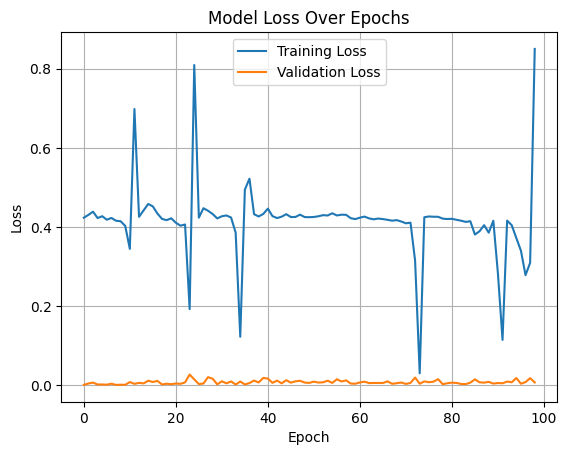

In [28]:

# If you have history from model.fit(...)
history_dict = history

# Plot training & validation loss
plt.plot(history_dict['train_loss'], label='Training Loss')

# Check if validation loss exists
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data = HeteroData()
for node in node_classes:

    node_features_df = pd.read_csv(os.path.join("save_path_numeric", f'pivoted_df_{node}.csv'), header=None).astype(float)
    node_tensor = torch.tensor(node_features_df.values, dtype=torch.float)
    id_mapping_df = pd.read_csv(os.path.join("path", f'pivoted_df_{node}.csv'))
    subject_mapping_dict = id_mapping_df.set_index('subject')['mapping'].to_dict()

    topo_df = pd.read_csv(f"save_path_numeric/uri_list_{node}.csv")
    topo_df['mapped_col'] = topo_df['subject'].map(subject_mapping_dict)
    topo_df = topo_df.sort_values(by='mapped_col')
    topo_df.drop(['subject', 'mapped_col'], axis=1, inplace=True)
    node_tensor_topo = torch.tensor(topo_df.values, dtype=torch.float)

    node_tensor = torch.concat([node_tensor, node_tensor_topo], dim=1)
    print(node_tensor.shape)
print(data)

In [ ]:
subprocess.run([python_executable, "autordf2gml-tb.py", "--config_path", "top-config.ini"], shell=False, capture_output=True, text=True, encoding='utf-8')

In [ ]:
def return_heterograph_for_one_nt(nt_file_name, node_names, edge_names):
    
    with tempfile.TemporaryDirectory() as temp_dir:
        save_path_numeric = os.path.join(temp_dir, "save_path_numeric")
        path = os.path.join(temp_dir, "path")
        os.makedirs(save_path_numeric, exist_ok=True)
        os.makedirs(path, exist_ok=True)

        content_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [NLD]
        nld_class = ModuleDefinition

        [EMBEDDING]
        embedding_model = allenai/scibert_scivocab_uncased

        

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [N-ArayFeaturePath]
        ComponentDefinition_Range_feature_path = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location

        [N-ArayFeatureValue]
        ComponentDefinition_Range_feature_value = http://sbols.org/v2#start, http://sbols.org/v2#end
        '''

        topo_config_string = f'''
        [InputPath]
        input_path = {os.path.join(nt_path, nt_file_name)}

        [SavePath]
        save_path_numeric_graph = {save_path_numeric}
        save_path_mapping = {path}

        [MODEL] ;required, options = transe / complex / distmult / rotate
        kge_model = distmult

        [Nodes]
        classes = ComponentDefinition, Sequence, ModuleDefinition, Module, FunctionalComponent, Component, SequenceAnnotation, Range

        ComponentDefinition = http://sbols.org/v2#ComponentDefinition
        Sequence = http://sbols.org/v2#Sequence
        ModuleDefinition = http://sbols.org/v2#ModuleDefinition
        Module = http://sbols.org/v2#Module
        FunctionalComponent = http://sbols.org/v2#FunctionalComponent
        Component = http://sbols.org/v2#Component
        SequenceAnnotation = http://sbols.org/v2#SequenceAnnotation
        Range = http://sbols.org/v2#Range

        [SimpleEdges]
        edge_names = ComponentDefinition_Sequence, ComponentDefinition_SequenceAnnotation
        ComponentDefinition_Sequence_start_node = ComponentDefinition
        ComponentDefinition_Sequence_properties = http://sbols.org/v2#sequence
        ComponentDefinition_Sequence_end_node = Sequence
        ComponentDefinition_SequenceAnnotation_start_node = ComponentDefinition
        ComponentDefinition_SequenceAnnotation_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_SequenceAnnotation_end_node = SequenceAnnotation

        [N-HopEdges]
        edge_names = ComponentDefinition_Range, ModuleDefinition_ComponentDefinition, ModuleDefinition_ModuleDefinition, ComponentDefinition_ComponentDefinition
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_hop1_properties = http://sbols.org/v2#sequenceAnnotation
        ComponentDefinition_Range_hop2_properties = http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range
        ModuleDefinition_ComponentDefinition_start_node = ModuleDefinition
        ModuleDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#functionalComponent
        ModuleDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ComponentDefinition_end_node = ComponentDefinition
        ModuleDefinition_ModuleDefinition_start_node = ModuleDefinition
        ModuleDefinition_ModuleDefinition_hop1_properties = http://sbols.org/v2#module
        ModuleDefinition_ModuleDefinition_hop2_properties = http://sbols.org/v2#definition
        ModuleDefinition_ModuleDefinition_end_node = ModuleDefinition
        ComponentDefinition_ComponentDefinition_start_node = ComponentDefinition
        ComponentDefinition_ComponentDefinition_hop1_properties = http://sbols.org/v2#component
        ComponentDefinition_ComponentDefinition_hop2_properties = http://sbols.org/v2#definition
        ComponentDefinition_ComponentDefinition_end_node = ComponentDefinition

        [N-ArayEdges]
        edge_names = ComponentDefinition_Range
        ComponentDefinition_Range_start_node = ComponentDefinition
        ComponentDefinition_Range_properties = http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#location
        ComponentDefinition_Range_end_node = Range

        [EmbeddingClasses] 
        class_list = http://sbols.org/v2#ComponentDefinition, http://sbols.org/v2#Sequence, http://sbols.org/v2#ModuleDefinition, http://sbols.org/v2#Module, http://sbols.org/v2#FunctionalComponent, http://sbols.org/v2#Component, http://sbols.org/v2#SequenceAnnotation, http://sbols.org/v2#Range

        [EmbeddingPredicates] 
        pred_list = http://sbols.org/v2#location, http://sbols.org/v2#sequenceAnnotation, http://sbols.org/v2#functionalComponent, http://sbols.org/v2#definition, http://sbols.org/v2#module, http://sbols.org/v2#component, https://sbols.org/v2#sequence, http://www.w3.org/1999/02/22-rdf-syntax-ns#type
        '''

        with open(os.path.join(temp_dir,'config.ini'), 'w') as file:
            file.write(content_config_string)

        with open(os.path.join(temp_dir,'topo-config.ini'), 'w') as file:
            file.write(topo_config_string)

        content_result = subprocess.run([python_executable, "autordf2gml.py", "--config_path", os.path.join(temp_dir,"config.ini")], shell=False, capture_output=True, text=True)
        topo_result = subprocess.run([python_executable, "autordf2gml-tb.py", "--config_path", os.path.join(temp_dir,"topo-config.ini")], shell=False, capture_output=True, text=True, encoding='utf-8', errors='replace')

        if (topo_result.returncode != 0):
            print(f"topology-based conversion failed with return code {topo_result.returncode}.")

        if (content_result.returncode != 0):
            print(f"content-based conversion failed with return code {content_result.returncode}.")
        
        data = HeteroData()
        local_indices_map = {}            

        for node_name in node_names:
            node_features_df = pd.read_csv(os.path.join(save_path_numeric, f'pivoted_df_{node_name}.csv'), header=None).astype(float)
            node_tensor = torch.tensor(node_features_df.values, dtype=torch.float)
            id_mapping_df = pd.read_csv(os.path.join(path, f'pivoted_df_{node_name}.csv'))
            subject_mapping_dict = id_mapping_df.set_index('subject')['mapping'].to_dict()

            topo_df = pd.read_csv(os.path.join(save_path_numeric, f"uri_list_{node_name}.csv"))
            topo_df['mapped_col'] = topo_df['subject'].map(subject_mapping_dict)
            topo_df = topo_df.sort_values(by='mapped_col')
            topo_df = topo_df.drop(['subject', 'mapped_col'], axis=1).astype(float)
            node_tensor_topo = torch.tensor(topo_df.values, dtype=torch.float)


            node_tensor = torch.concat([node_tensor, node_tensor_topo], dim=1)
            
            data[node_name].node_id = torch.arange(len(id_mapping_df))
            data[node_name].x = node_tensor
            local_indices_map = subject_mapping_dict | local_indices_map
                
        for edge in edge_names:
            df = pd.read_csv( os.path.join(save_path_numeric, f"edge_list_{edge}.csv"), header=None)
            
            src = df[0].values
            dst = df[1].values

            src = torch.tensor([local_indices_map[src[i]] for i in range(len(src))], dtype=torch.long)
            dst = torch.tensor([local_indices_map[dst[i]] for i in range(len(dst))], dtype=torch.long)
            data[edge.split("_")[0], f'has_{edge.split("_")[1]}', edge.split("_")[1]].edge_index = torch.stack([src, dst], dim=0)
        
        return data